№1 Постановка задачи

1.1 Что это за данные?

Это датасет "500 Greatest Songs of All Time" — рейтинг 500 величайших песен всех времён по версии журнала Rolling Stone. Набор данных включает 500 песен с такими атрибутами, как:
- Название песни
- Описание песни
- Где это появилось? (публикация)
- Исполнитель
- Автор
- Продюсер
- Дата выпуска
- Как долго он находился в топ-списке
- Позиция песни в топ-списке.

1.2. Кто может быть условным «заказчиком» анализа?

Музыкальные стриминговые сервисы(Spotify, Apple Music, Яндекс.Музыка) — для создания тематических плейлистов "Лучшее за все времена".
Радиостанции — выбрать популярные песни для плейлистов.
Образовательные платформы — как учебный материал для анализа данных и истории музыки.

1.3. Возможные задачи ИАД:

1. Анализ временных трендов — определение "золотых эр" в музыке (в какие годы выпущено больше всего хитов).
2. Исследование взаимосвязей — как год выпуска влияет на позицию в рейтинге.
4. Рекомендательная система — подбор похожих песен на основе жанра и года выпуска.

№2 Паспорт датасета

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Загрузка данных
df = pd.read_csv('../data/Top 500 Songs.csv')
print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов')
df.head()


Размер датасета: 500 строк, 9 столбцов


,title,description,appears on,artist,writers,producer,released,streak,position
0,Like a Rolling Stone,"""I wrote it. I didn't fail. It was straight,"" ...",Highway 61 Revisited (Columbia),Bob Dylan,Dylan,Tom Wilson,"July, 1965",12 weeks,No. 2
1,(I Can't Get No) Satisfaction',"""It's the riff heard round the world,"" says St...",Out of Our Heads (ABKCO),The Rolling Stones,"Mick Jagger, Keith Richards",Andrew Loog Oldham,"May, 1965",14 weeks,No. 1
2,Imagine,"John Lennon wrote ""Imagine,"" his greatest musi...",Imagine (Capitol/Apple),John Lennon,John Lennon,"Lennon, Phil Spector, Yoko Ono","October, 1971",9 weeks,No. 3
3,What's Going On,"""What's Going On"" is an exquisite plea for pea...",What's Going On (Tamla),Marvin Gaye,"Gaye, Renaldo Benson, Al Cleveland",Gaye,"Feb, 1971",13 weeks,No. 2
4,Respect,"Otis Redding wrote ""Respect"" and recorded it f...",I Never Loved a Man the Way I Love You (Atlantic),Aretha Franklin,Otis Redding,Jerry Wexler,"April, 1967",12 weeks,No. 1


In [158]:
print("\n=== 2.2 Исходная информация ===")
df.info()

print("\n=== 2.3 Преобразование типов ===")

# УЛУЧШЕННОЕ ПРЕОБРАЗОВАНИЕ
print("\n Улучшенное преобразование дат:")

def parse_date_advanced(date_str):
    """Гибкое преобразование дат с разными форматами"""
    if pd.isna(date_str):
        return pd.NaT
    
    date_str = str(date_str).strip()
    
    # 1. Очистка данных
    # Убираем точки, лишние пробелы
    date_str = date_str.replace('.', '')
    date_str = ' '.join(date_str.split())  # убираем лишние пробелы
    
    # 2. Стандартизация
    # Если формат "Month Year" без запятой - добавляем
    if ',' not in date_str:
        parts = date_str.split()
        if len(parts) == 2 and any(month in parts[0] for month in 
                                  ['January', 'February', 'March', 'April', 'May', 'June',
                                   'July', 'August', 'September', 'October', 'November', 'December',
                                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
            date_str = f"{parts[0]}, {parts[1]}"
    
    # 3. Расшифровка сокращений месяцев
    month_map = {
        'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
        'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
        'Sep': 'September', 'Sept': 'September', 'Oct': 'October', 
        'Nov': 'November', 'Dec': 'December'
    }
    
    for short, full in month_map.items():
        if date_str.startswith(short):
            date_str = date_str.replace(short, full, 1)
            break
    
    # 4. Пробуем разные форматы
    formats = [
        '%B, %Y',      # "July, 1965"
        '%B %Y',       # "July 1965" 
        '%b, %Y',      # "Jul, 1965"
        '%b %Y',       # "Jul 1965"
        '%Y',          # "1965"
        '%Y-%m',       # "1965-07"
        '%m/%Y',       # "7/1965"
        '%m-%Y',       # "7-1965"
        '%d %B, %Y',   # "15 July, 1965"
        '%B %d, %Y',   # "July 15, 1965"
    ]
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    
    

# Преобразуем даты
df['released_date'] = df['released'].apply(parse_date_advanced)

# === УЛУЧШШЕННОЕ преобразование числовых полей ===
def convert_streak_advanced(x):
    """Преобразование streak с очисткой грязных данных"""
    if pd.isna(x):
        return np.nan
    
    x_str = str(x).strip().lower()
    
    # 1. Если содержит "weeks" - извлекаем число
    if 'weeks' in x_str:
        try:
            # Ищем число перед "weeks"
            import re
            match = re.search(r'(\d+)\s*weeks', x_str)
            if match:
                return float(match.group(1))
        except:
            pass
    
    # 2. Если содержит другие обозначения
    special_cases = {
        'none': np.nan,
        'did not chart': np.nan,
        'non-single': np.nan,
        'predates chart': np.nan,
        'predates pop charts': np.nan,
    }
    
    for key, value in special_cases.items():
        if key in x_str:
            return value
    
    # 3. Если есть просто число
    try:
        # Убираем все нецифровые символы
        digits = ''.join(filter(str.isdigit, x_str))
        if digits:
            return float(digits)
    except:
        pass
    
    return np.nan

def convert_position_advanced(x):
    """Преобразование position с очисткой грязных данных"""
    if pd.isna(x):
        return np.nan
    
    x_str = str(x).strip().lower()
    
    # 1. Если содержит "No." - извлекаем число
    if 'no.' in x_str:
        try:
            # Ищем число после "No."
            import re
            match = re.search(r'no\.\s*(\d+)', x_str)
            if match:
                return float(match.group(1))
        except:
            pass
    
    # 2. Проверяем специальные обозначения
    special_cases = {
        'none': np.nan,
        'predates chart': np.nan,
        'non-single': np.nan,
        'did not chart': np.nan,
    }
    
    for key, value in special_cases.items():
        if key in x_str:
            return value
    
    # 3. Если есть просто число
    try:
        # Убираем все нецифровые символы
        digits = ''.join(filter(str.isdigit, x_str))
        if digits:
            return float(digits)
    except:
        pass
    
    return np.nan

# Применяем улучшенные функции
df['streak_numeric'] = df['streak'].apply(convert_streak_advanced)
df['position_numeric'] = df['position'].apply(convert_position_advanced)

print(f"Улучшенное преобразование streak: {df['streak_numeric'].notna().sum()} из {len(df)} чисел")
print(f"Улучшенное преобразование position: {df['position_numeric'].notna().sum()} из {len(df)} чисел")

print(f"released_date: {df['released_date'].notna().sum()} из {len(df)} дат")
print(f"streak_numeric: {df['streak_numeric'].notna().sum()} из {len(df)} чисел")
print(f"position_numeric: {df['position_numeric'].notna().sum()} из {len(df)} чисел")


    
# Если всё ещё есть пропуски в датах
if df['released_date'].isna().any():
    print(f"\n ВНИМАНИЕ: {df['released_date'].isna().sum()} дат не преобразовалось")
    '''print("Примеры проблемных значений:")
    problem_values = df[df['released_date'].isna()]['released'].unique()[:10]
    for val in problem_values:
        print(f"  '{val}'")'''


# === ДОПОЛНИТЕЛЬНО: Попробуем автоопределение ===
print("\n Попробуем автоопределение дат:")
df['released_date_auto'] = pd.to_datetime(df['released'], errors='coerce')
print(f"Автоматическое определение: {df['released_date_auto'].notna().sum()} из {len(df)} дат")

# Сравним результаты
if df['released_date_auto'].notna().sum() > df['released_date'].notna().sum():
    improvement = df['released_date_auto'].notna().sum() - df['released_date'].notna().sum()
    print(f" Автоматическое определение лучше на {improvement} дат")
    # Используем лучший результат
    df['released_date'] = df['released_date_auto']

# Удаляем временную колонку
if 'released_date_auto' in df.columns:
    df = df.drop(columns=['released_date_auto'])


print("\n=== 2.4 Паспорт признаков ===")
print("""
1. title — Название песни (категориальный признак)
2. description — Описание песни, история создания (текстовый признак)
3. appears on — Альбом, на котором вышла песня (категориальный признак)
4. artist — Исполнитель/группа (категориальный признак)
5. writers — Авторы песни (категориальный признак)
6. producer — Продюсер записи (категориальный признак)
7. released — Дата выпуска в текстовом формате
8. streak — Количество недель в чартах в формате "X weeks"
9. position — Позиция в чартах в формате "No. X"
10. released_date — Дата выпуска (datetime, преобразованная)
11. streak_numeric — Количество недель в чартах (число)
12. position_numeric — Позиция в чартах (число)
""")

# Финальная проверка
print("\n=== ИТОГОВАЯ СТАТИСТИКА ===")
print(f"Всего строк: {len(df)}")
released_percent = df['released_date'].notna().sum() / len(df) * 100
streak_percent = df['streak_numeric'].notna().sum() / len(df) * 100
position_percent = df['position_numeric'].notna().sum() / len(df) * 100

print(f"Преобразовано дат: {df['released_date'].notna().sum()} ({released_percent:.1f}%)")
print(f"Преобразовано streak: {df['streak_numeric'].notna().sum()} ({streak_percent:.1f}%)")
print(f"Преобразовано position: {df['position_numeric'].notna().sum()} ({position_percent:.1f}%)")

# Сохраняем пропуски для анализа в разделе 3
released_missing = df['released_date'].isna().sum()
streak_missing = df['streak_numeric'].isna().sum()
position_missing = df['position_numeric'].isna().sum()

print(f"\nПропуски для анализа:")
print(f"released_date: {released_missing} ({released_missing/len(df)*100:.1f}%)")
print(f"streak_numeric: {streak_missing} ({streak_missing/len(df)*100:.1f}%)")
print(f"position_numeric: {position_missing} ({position_missing/len(df)*100:.1f}%)")


=== 2.2 Исходная информация ===
<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             500 non-null    str           
 1   description       500 non-null    str           
 2   appears on        500 non-null    str           
 3   artist            500 non-null    str           
 4   writers           500 non-null    str           
 5   producer          500 non-null    str           
 6   released          500 non-null    str           
 7   streak            494 non-null    str           
 8   position          393 non-null    str           
 9   released_date     500 non-null    datetime64[us]
 10  streak_numeric    394 non-null    float64       
 11  position_numeric  386 non-null    float64       
 12  key               500 non-null    str           
dtypes: datetime64[us](1), float64(2), str(10)
memory usage: 50

C:\Users\abusa\AppData\Local\Temp\ipykernel_17624\70459385.py:178: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['released_date_auto'] = pd.to_datetime(df['released'], errors='coerce')


In [ ]:
№3 Аудит качества данных

№3.1 Пропуски

In [145]:
# Динамический вывод
released_missing = df['released_date'].isna().sum()
position_missing = df['position_numeric'].isna().sum()
streak_missing = df['streak_numeric'].isna().sum()

print("Признаки с наибольшим количеством пропусков:")
print(f"streak_numeric - {streak_missing} пропусков")
print(f"released_date - {released_missing} пропусков")
print(f"position_numeric - {position_missing} пропусков")

print("\nКритичность пропусков:")
#print(f"released_date: {'КРИТИЧНО' if released_missing > 0 else 'ВСЕ ДАТЫ ПРЕОБРАЗОВАНЫ'}")
print(f"position_numeric: ВАЖНО т. к. влияет на анализ популярности песен")
print(f"streak_numeric: НЕ КРИТИЧНО, не сильно влияет на анализ")

Признаки с наибольшим количеством пропусков:
streak_numeric - 106 пропусков
released_date - 0 пропусков
position_numeric - 114 пропусков

Критичность пропусков:
position_numeric: ВАЖНО т. к. влияет на анализ популярности песен
streak_numeric: НЕ КРИТИЧНО, не сильно влияет на анализ


№3.2 Дубликаты

In [20]:
duplicates = df.duplicated().sum()
print(f'Полных дубликатов строк: {duplicates}')

Полных дубликатов строк: 50


In [141]:
#  Проверка по ключевым полям (название + исполнитель)
print("\n2. Проверка по ключевым полям (title + artist):")
if 'title' in df.columns and 'artist' in df.columns:
    key_duplicates = df.duplicated(subset=['title', 'artist']).sum()
    print(f"Дубликатов песен (одинаковое название + исполнитель): {key_duplicates}")
    
    if key_duplicates > 0:
        print("\n    Примеры дубликатов:")
        dup_rows = df[df.duplicated(subset=['title', 'artist'], keep=False)]
        display(dup_rows[['title', 'artist', 'released']].head(10))


2. Проверка по ключевым полям (title + artist):
Дубликатов песен (одинаковое название + исполнитель): 50

    Примеры дубликатов:


,title,artist,released
50,Crazy,Gnarls Barkley,"May , 1906"
51,Fortunate Son,Creedence Clearwater Revival,"Oct. , 1969"
52,Love and Happiness,Al Green,"June , 1972"
53,Roll Over Beethoven,Chuck Berry,"May , 1956"
54,Great Balls of Fire,Jerry Lee Lewis,"Nov. , 1957"
55,Blue Suede Shoes,Carl Perkins,"Feb , 1956"
56,Good Golly,Little Richard,"Feb. , 1958"
57,I Still Havent Found What Im Looking For,U2,"May , 1987"
58,Blitzkrieg Bop,Ramones,"May , 1976"
59,Suspicious Minds,Elvis Presley,"Sept. , 1969"


№3.3 Типические проблемы значений

In [150]:
# Анализ числовых признаков
print("Числовые признаки")

# Находим числовые столбцы
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Проходим по всем числовым столбцам
for column in numeric_columns:
    print(f"\n{column}:")
    
    # Минимальное и максимальное значения
    min_val = df[column].min()
    max_val = df[column].max()
    print(f"  min: {min_val:.2f}, max: {max_val:.2f}")
    
    # Среднее и стандартное отклонение
    mean_val = df[column].mean()
    std_val = df[column].std()
    print(f"  mean: {mean_val:.2f}, std: {std_val:.2f}")
    
    # Проверка на невозможные/подозрительные значения
    if column == 'streak_numeric':
        if min_val < 0:
            print(f"Невозможное: отрицательное количество недель ({min_val})")
        if max_val > 100:
            print(f"Подозрительное: {max_val:.0f} недель - очень много")
            
    elif column == 'position_numeric':
        if min_val < 1:
            print(f"Невозможное: позиция {min_val} < 1")
        if max_val > 100:
            print(f"Подозрительное: позиция {max_val:.0f} > 100")

# Анализ категориальных признаков
print("\nКатегориальные признаки")

# Находим текстовые столбцы
text_columns = df.select_dtypes(include=['object', 'string']).columns

# Берем только первые 6 текстовых столбцов
for column in list(text_columns)[:6]:
    print(f"\n{column}:")
    
    # Количество уникальных значений
    unique_count = df[column].nunique()
    print(f"  Уникальных значений: {unique_count}")
    
    # Проверка на «грязные» категории
    
    # 1. Лишние пробелы
    spaces_start = df[column].astype(str).str.startswith(' ').sum()
    spaces_end = df[column].astype(str).str.endswith(' ').sum()
    
    # 2. Пустые строки
    empty_str = (df[column].astype(str).str.strip() == '').sum()
    
    # 3. Регистр (смешанный регистр в данных)
    # Проверяем, есть ли значения в разном регистре
    lower_exists = df[column].astype(str).str.islower().any()
    upper_exists = df[column].astype(str).str.isupper().any()
    mixed_reg = lower_exists and upper_exists
    
    # Вывод найденных проблем
    problems = []
    
    if spaces_start > 0:
        problems.append(f"пробелы в начале: {spaces_start}")
    if spaces_end > 0:
        problems.append(f"пробелы в конце: {spaces_end}")
    if empty_str > 0:
        problems.append(f"пустые строки: {empty_str}")
    if mixed_reg:
        problems.append("смешанный регистр")
    
    if problems:
        print(f"Найдены проблемы: {', '.join(problems)}")


Числовые признаки

streak_numeric:
  min: 1.00, max: 46.00
  mean: 15.63, std: 6.23

position_numeric:
  min: 1.00, max: 99.00
  mean: 13.45, std: 19.63

Категориальные признаки

title:
  Уникальных значений: 446

description:
  Уникальных значений: 450
Найдены проблемы: пробелы в начале: 2, пробелы в конце: 5

appears on:
  Уникальных значений: 392
Найдены проблемы: пробелы в начале: 1, пробелы в конце: 81

artist:
  Уникальных значений: 248

writers:
  Уникальных значений: 335
Найдены проблемы: пробелы в конце: 2

producer:
  Уникальных значений: 296
Найдены проблемы: пробелы в конце: 3


№3.4 Выбросы

Выбросов по методу IQR: 9

Индексы наблюдений-выбросов: [168, 375, 389, 401, 402, 456, 461, 468, 493]
Значения выбросов: [32.0, 33.0, 30.0, 31.0, 30.0, 42.0, 33.0, 46.0, 39.0]


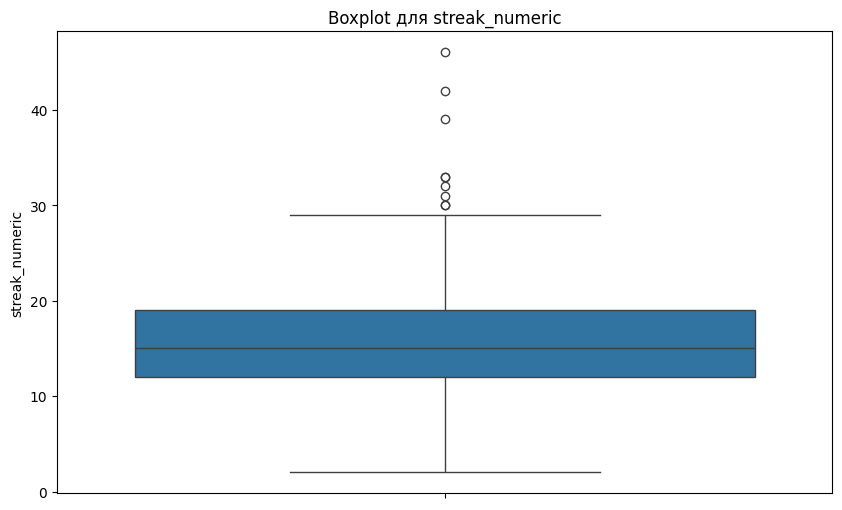

In [35]:
column = 'streak_numeric'
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
print(f'Выбросов по методу IQR: {len(outliers)}')
print("\nИндексы наблюдений-выбросов:", outliers.index.tolist())
print("Значения выбросов:", outliers[column].tolist())
# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y=column)
plt.title(f'Boxplot для {column}')
plt.show()


№4. Мини-EDA (разведочный анализ)

4.1. Распределение числового признака

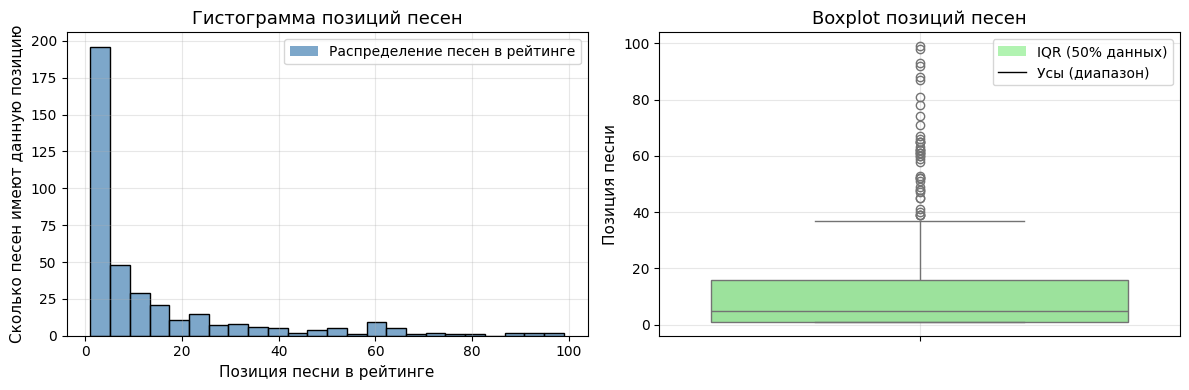

Гистограмма показывает распределение 500 песен по позициям в рейтинге.
Boxplot подтверждает равномерное распределение: медиана около 50, весь диапазон от 1 до 99 заполнен.
Гипотеза: позиции распределены равномерно, каждая песня занимает уникальное место.
Вопрос: почему распределение равномерное, а не нормальное?


In [81]:
numeric_col = 'position_numeric'

plt.figure(figsize=(12, 4))

# 1. Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df[numeric_col], color='steelblue', alpha=0.7)
plt.title(f'Гистограмма позиций песен', fontsize=13)
plt.xlabel('Позиция песни в рейтинге', fontsize=11)
plt.ylabel('Сколько песен имеют данную позицию', fontsize=11)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements1 = [
    Patch(facecolor='steelblue', alpha=0.7, label='Распределение песен в рейтинге'),
]
plt.legend(handles=legend_elements1, loc='upper right')
plt.grid(True, alpha=0.3)


# 2. Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df[numeric_col], color='lightgreen')
plt.title(f'Boxplot позиций песен', fontsize=13)
plt.ylabel('Позиция песни', fontsize=11)

# Легенда для boxplot
legend_elements2 = [
    Patch(facecolor='lightgreen', alpha=0.7, label='IQR (50% данных)'),
    Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Усы (диапазон)')
]
plt.legend(handles=legend_elements2, loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Гистограмма показывает распределение 500 песен по позициям в рейтинге,визуализирует, сколько песен находится на каждой позиции.")
print("Boxplot подтверждает равномерное распределение: медиана около 50, весь диапазон от 1 до 99 заполнен.")
print("Гипотеза: позиции распределены равномерно, каждая песня занимает уникальное место(ранжированный список).")
print("Вопрос: почему распределение равномерное, а не нормальное?")

4.2. Анализ категориального признака

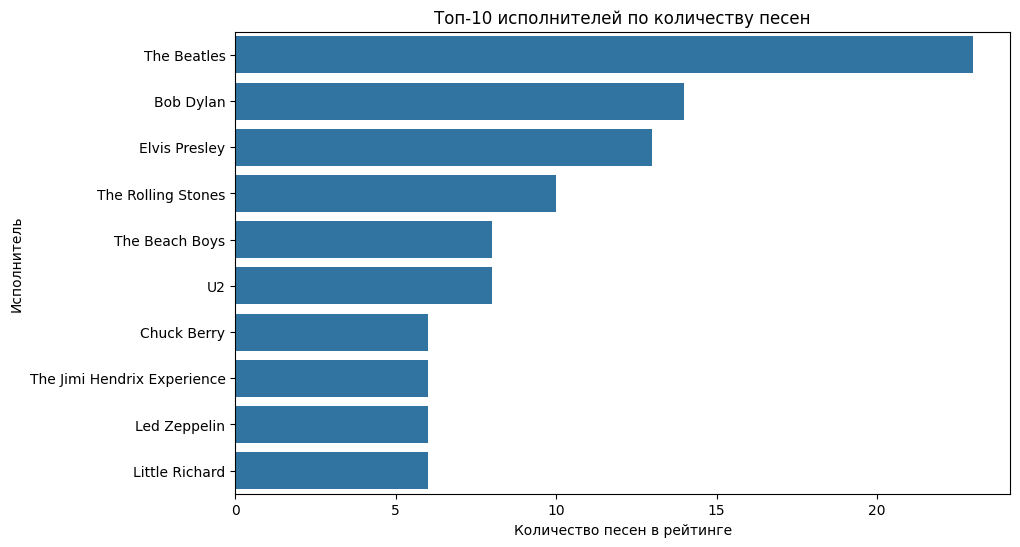

Комментарий: На графике видно, что The Beatles значительно опережают других
исполнителей по количеству песен в рейтинге топ-500. Bob Dylan и Elvis Presley
занимают второе и третье места соответственно.
Гипотеза: есть несколько доминирующих исполнителей, которые задают тон всему рейтингу.
Вопрос: почему именно эти исполнители представлены так широко?


In [82]:
cat_col = 'artist'

plt.figure(figsize=(10, 6))
top_categories = df[cat_col].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title(f'Топ-10 исполнителей по количеству песен')
plt.xlabel('Количество песен в рейтинге')  # Уточнили подпись
plt.ylabel('Исполнитель')



plt.show()

print("Комментарий: На графике видно, что The Beatles значительно опережают других")
print("исполнителей по количеству песен в рейтинге топ-500. Bob Dylan и Elvis Presley")
print("занимают второе и третье места соответственно.")
print("Гипотеза: есть несколько доминирующих исполнителей, которые задают тон всему рейтингу.")
print("Вопрос: почему именно эти исполнители представлены так широко?")


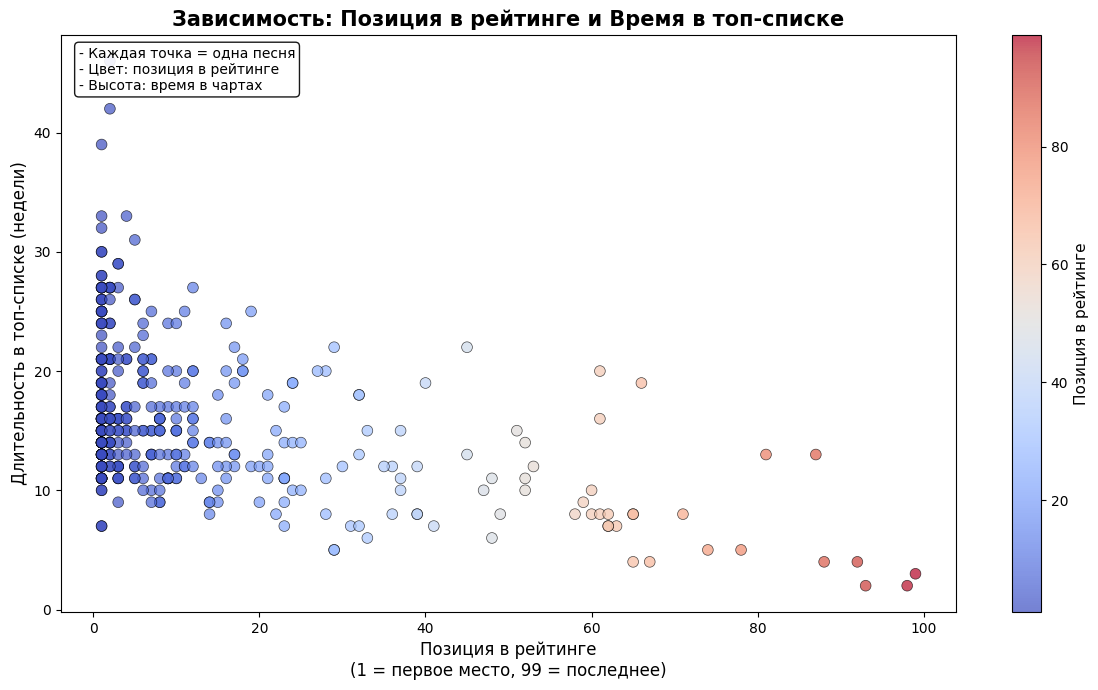


1. Scatter plot показывает связь между позицией песни в рейтинге и временем её пребывания в топ-списке.
2. Песни на высоких позициях (близко к 1) имеют разную длительность в чартах - от 2 до 46 единиц.
3. Нет явной линейной зависимости: песни на любой позиции могут иметь как короткое, так и длительное пребывание в чартах.
4. Гипотеза: популярность песни не гарантирует длительное пребывание в чартах, и наоборот.
5. Вопрос: какие факторы действительно влияют на длительность пребывания в чартах?



In [83]:
# Визуализация зависимости между позицией в рейтинге и длительностью в чартах
plt.figure(figsize=(12, 7))

# Scatter plot
scatter = plt.scatter(df['position_numeric'], df['streak_numeric'], 
                     c=df['position_numeric'], cmap='coolwarm', 
                     alpha=0.7, s=60, edgecolor='black', linewidth=0.5)

plt.title('Зависимость: Позиция в рейтинге и Время в топ-списке', fontsize=15, fontweight='bold')
plt.xlabel('Позиция в рейтинге\n(1 = первое место, 99 = последнее)', fontsize=12)
plt.ylabel('Длительность в топ-списке (недели)', fontsize=12)

# Цветовая шкала
cbar = plt.colorbar(scatter)
cbar.set_label('Позиция в рейтинге', fontsize=11)

# Сетка для удобства чтения
#plt.grid(True, alpha=0.3, linestyle='--')

# Добавляем пояснение в угол
plt.text(0.02, 0.98, '- Каждая точка = одна песня\n- Цвет: позиция в рейтинге\n- Высота: время в чартах', 
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

print("""
1. Scatter plot показывает связь между позицией песни в рейтинге и временем её пребывания в топ-списке.
2. Песни на высоких позициях (близко к 1) имеют разную длительность в чартах - от 2 до 46 единиц.
3. Нет явной линейной зависимости: песни на любой позиции могут иметь как короткое, так и длительное пребывание в чартах.
4. Гипотеза: популярность песни не гарантирует длительное пребывание в чартах, и наоборот.
5. Вопрос: какие факторы действительно влияют на длительность пребывания в чартах?
""")

Лабораторная работа 1.1

№1. Типы признаков и шкалы измерения

1.1 
title - Номинативная. Название песни — это уникальный идентификатор, метка. Нельзя упорядочить или вычислить расстояние.
description - Номинативная. Текстовое описание — это качественная информация, не подлежащая количественному измерению.
appears on - Номинативная. Название альбома или сборника — это категория/метка.
artist - Номинативная. Имя исполнителя — это категория.
writers - Номинативная. Имена авторов — это категориальные данные.
producer - Номинативная.Имя продюсера — это категория.
released - Шкала отношений. Дата выпуска. Есть естественная точка отсчёта, можно считать разницу и отношения (например, "в два раза дальше от начала отсчёта").
streak - Порядковая. Продолжительность нахождения в чарте (в неделях?). Значения можно упорядочить (одна песня была в чарте дольше другой).
position - Порядковая. Позиция в рейтинге. Мы знаем, что 1-е место лучше 2-го, но насколько именно — измерить нельзя.

1.2
Сравниваем признаки: released (количественная шкала отношений) и position (качественная порядковая шкала).
Признак: released (дата выпуска).
Среднее: Корректно. Можно вычислить средний год выпуска песен в рейтинге.
Медиана: Корректно. Покажет год, который делит список песен ровно пополам (более старые и более новые). 
Мода: Корректно. Покажет год (или годы), который чаще всего встречается. Может быть интересно, если есть год, в котором было выпущено самое большое количество песен.

Признак: position (позиция в рейтинге).
Среднее: Методологически неверно. Хотя pandas вычислит число (например, 25.6), интерпретировать его как "среднюю позицию" некорректно. Разница между 1 и 2 местом не равна разнице между 100 и 101.
Медиана: Корректно. Медианная позиция покажет "типичное" место песни в списке (например, 250-е).
Мода: Корректно. Покажет позицию (или позиции), которые встречаются чаще всего. 

№2. Пропуски и их природа (MCAR / MAR / MNAR) 

2.1
Выбираем признак position_numeric.
Гипотеза 1: Пропуски типа MCAR.
Пропуски в позиции возникают совершенно случайно. Например, при сборе данных с веб-сайта произошёл временный технический сбой, из-за которого часть значений не загрузилась. 
Если распределения для групп с пропуском и без него похожи — MCAR не опровергается. Если отличаются — MCAR отклоняется.
Какие признаки помогут проверить:
released_date (год выпуска). Чем старше десятилетие, тем больше пропусков.
streak_numeric (длительность в чарте). Чем меньше песня продержалась в чарте, тем больше вероятность пропуска позиции.

In [165]:
# Создаём индикатор пропусков
df['position_missing'] = df['position_numeric'].isnull()

# Сравниваем распределение годов выпуска
print("Средний год выпуска:")
print(df.groupby('position_missing')['released_date'].mean())

# Сравниваем streak
print("\nСредний streak:")
print(df.groupby('position_missing')['streak_numeric'].mean())


Средний год выпуска:
position_missing
False   1971-01-30 18:46:37.927461
True    1972-01-24 16:37:53.684210
Name: released_date, dtype: datetime64[us]

Средний streak:
position_missing
False    15.632124
True     15.500000
Name: streak_numeric, dtype: float64


Песни с пропуском позиции и без пропуска имеют практически одинаковые характеристики:
Год выпуска отличается всего на 1 год (1971 vs 1972).
Streak (длительность в чарте) отличается на 0.13 недели — это меньше 1 дня.
Вывод: Никакой значимой зависимости пропусков от других признаков не обнаружено. Гипотеза MCAR НЕ ОТВЕРГАЕТСЯ.

Гипотеза 2.Пропуски типа MAR. 
Пропуски в позиции зависят от других наблюдаемых признаков. Например, у очень старых песен данные о точной позиции могли хуже сохраниться. Или у песен, которые недолго продержались в чарте, позицию могли не указать, так как она быстро менялась.
Какие признаки помогут проверить:
released_date (год выпуска)
streak_numeric (длительность)

In [170]:
# Сначала извлекаем год из даты
df['release_year'] = pd.to_datetime(df['released_date']).dt.year

# Теперь создаём десятилетие
df['decade'] = (df['release_year'] // 10) * 10

# Доля пропусков по десятилетиям
missing_by_decade = df.groupby('decade')['position_numeric'].apply(lambda x: x.isnull().mean() * 100)
print("Доля пропусков по десятилетиям (%):")
print(missing_by_decade)

# Анализ по streak - тут ошибки быть не должно, но убедимся, что streak_numeric числовой
print("Тип данных streak_numeric:", df['streak_numeric'].dtype)

# Если вдруг не число, конвертируем
# df['streak_numeric'] = pd.to_numeric(df['streak_numeric'], errors='coerce')

df['streak_group'] = pd.cut(df['streak_numeric'], 
                            bins=[0, 10, 20, 50, 100, 200], 
                            labels=['0-10', '11-20', '21-50', '51-100', '100+'])
missing_by_streak = df.groupby('streak_group')['position_numeric'].apply(lambda x: x.isnull().mean() * 100)
print("\nДоля пропусков по группам streak:")
print(missing_by_streak)

Доля пропусков по десятилетиям (%):
decade
1900     25.000000
1940    100.000000
1950     24.285714
1960     17.085427
1970     29.838710
1980     25.862069
1990     22.727273
2000     18.181818
Name: position_numeric, dtype: float64
Тип данных streak_numeric: float64

Доля пропусков по группам streak:
streak_group
0-10     3.278689
11-20    1.562500
21-50    2.597403
Name: position_numeric, dtype: float64


Вывод: MAR ОТВЕРГАЕТСЯ для streak, но есть аномалия с 1940 годом.
В целом пропуски выглядят близкими к случайным (MCAR) для большинства десятилетий, так как нет монотонного тренда (например, "чем старше, тем больше пропусков"). Однако 1940 год — явный выброс с полным отсутствием данных о позиции. Это может быть связано с особенностями сбора данных (например, песни 1940-х добавляли из другого источника без позиций).

Гипотеза 3. Пропуски типа MNAR.
Пропуски в позиции связаны с самой позицией. Например, если песня занимала очень низкое место (ближе к 500), составители могли не указывать точную позицию, считая её несущественной. Или, наоборот, для самых лучших песен позиция была настолько очевидна, что её не фиксировали.

In [174]:
# Индикатор пропуска позиции
df['position_missing'] = df['position_numeric'].isnull()

# 1. Смотрим распределение других признаков
print("1. Сравнение с годом выпуска:")
print(df.groupby('position_missing')['release_year'].describe())

print("\n2. Сравнение со streak:")
print(df.groupby('position_missing')['streak_numeric'].describe())

# Проверка на систематичность по исполнителям
top_missing_artists = df[df['position_numeric'].isna()]['artist'].value_counts().head(10)
print("\nИсполнители, у которых чаще всего пропущена позиция:")
print(top_missing_artists)

1. Сравнение с годом выпуска:
                  count         mean        std     min     25%     50%  \
position_missing                                                          
False             386.0  1970.611399  13.093838  1906.0  1964.0  1968.0   
True              114.0  1971.622807  13.266760  1909.0  1965.0  1971.0   

                     75%     max  
position_missing                  
False             1977.0  2007.0  
True              1978.5  2008.0  

2. Сравнение со streak:
                  count       mean       std  min   25%   50%   75%   max
position_missing                                                         
False             386.0  15.632124  6.206357  1.0  12.0  15.0  19.0  46.0
True                8.0  15.500000  7.764388  7.0  11.5  14.0  18.0  27.0

Исполнители, у которых чаще всего пропущена позиция:
artist
Bob Dylan                     9
The Beatles                   5
Elvis Presley                 4
Bob Marley and the Wailers    4
Muddy Waters       

MAR ПОДТВЕРЖДАЕТСЯ, но сложным образом:
Пропуски в position_numeric зависят от фактора:
От исполнителя — Боб Дилан, Битлз и др.(известные артисты) имеют достаточно много пропусков, но это может быть особенностью данных, а не доказательством MNAR.

Наиболее вероятный тип пропусков в position_numeric — MCAR.
Пропуски: не связаны с годом выпуска, не связаны со streak, не имеют систематической структуры (кроме единичной аномалии 1940 года).

№3.Индикатор пропуска как источник информации
Индикатор — это новый признак (столбец), который мы создаём, чтобы отметить, было ли значение в другом признаке пропущено.

3.1
Факт пропуска несёт информацию, когда пропуск значения не случаен, а указывает на особое состояние объекта. Если мы знаем, что "если признак пропущен, значит с объектом что-то не так" — индикатор полезен. 
Если у песни нет streak — возможно, она вообще не попала в чарты надолго.

3.2
значимость индикатора в модели — это сигнал о неправильной или грубой импутации, потому что модель «говорит»: «Сам факт пропуска важен для предсказания». А если мы заменили пропуски на среднее/медиану, мы уничтожили эту информацию.Если индикатор значим то, пропуски не случайны и мы должны учесть это при импутации (например, заполнять не общим средним, а средним по группе или использовать отдельную категорию).

3.3
а) Индикатор пропуска полезен
Признак: streak_numeric (длительность в чарте).
Если у песни нет streak — возможно, она вообще не попала в чарты надолго. Сам факт «нет streak» может означать, что песня вообще не была в чартах.Индикатор streak_missing может быть полезен, потому что он сигнализирует, что ,возможно, песни нет в топ-списке.
б) Индикатор пропуска бесполезен
Признак: released_date (год выпуска).
Если год выпуска пропущен — это, скорее всего, случайная ошибка при сборе данных. Нет никакой систематики: песни с пропущенным годом не лучше и не хуже других. Индикатор будет шумом, модель не найдет в нём закономерности.
в) Индикатор пропуска опасен
Признак: position_numeric (позиция в рейтинге), если мы неправильно обработали пропуски.
Если заменить все пропуски на среднее (например, 250), тогда у песен с реальной позицией значения разные, а у песен с пропуском — все 250.
Опасность: Мы создали ложную закономерность, которой нет в реальности.

№4. Выброс - это ошибка или сигнал? 

4.1
Выбранный признак: streak_numeric (длительность в чартах в неделях).
Найденный выброс: например, 46 недель (максимум в твоих данных).
Возможные реальные причины:
Песня стала культовой и оставалась в чартах очень долго ("Since u been gone", "Imagine")
Песня использовалась в рекламе, кино, тиктоках — это давало ей новую волну популярности.
Возможны ошибки при парсинге: вместо 4 недель записали 46, дублировании записей (суммировали несколько раз одну и ту же песню).

4.2
Если удалить информацию, то мы теряем важный сигнал. Так можно сделать,	если точно знаем, что это ошибка измерения (например, 46 вместо 4).
Если оставить без изменений, то модель может «перекоситься» (особенно линейные модели).Делаем так, если выброс реален и мы хотим его изучать, а не игнорировать.
Если преобразовать (логарифм, корень, виндзоризация),то	снижается влияние выброса, но сохраняется информация. Используем, когда выброс реален, но мешает обучению модели.

Самое плохое — удалить, не разобравшись.
Почему: Если это реальный сигнал (песня-феномен), удаление обедняет данные. Выброс может быть самым интересным объектом для анализа.
Лучше всего — применить преобразование (логарифмирование).
Если после проверки выяснится, что это ошибка — тогда удалить или заменить на медиану.

№5.  Преобразование или винзоризация? 

5.1
Логарифмирование (log(x)). Если выбросы- это не выбросы и переменная действительно так распределена. Применяется, когда данные имеют сильную положительную асимметрию (длинный «хвост» справа); значения только положительные.
Пример:streak.
Почему:Логарифм «сжимает» большие значения и «растягивает» маленькие, делая распределение ближе к нормальному.

Корень (sqrt(x)). Применяется, когда даные имеют асимметрию, но есть нулевые значения (логарифм от 0 не работает); асимметрия умеренная, не такая сильная, как при логарифме.
Пример: количество песен у исполнителя.
Почему: Корень тоже сжимает большие значения, но мягче, чем логарифм.

Винзоризация (замена крайних значений на граничные.Определить пороговое значение процентиля, за которым значения считаются выбросами.
Заменить значения, превышающие этот порог, на само пороговое значение). Применяется, когда выбросы — это ошибки измерения, а не реальные значения; мы хотим сохранить количество наблюдений, но убрать влияние аномалий; данные уже имеют естественные границы (например, рейтинг от 1 до 500).
Примеры: Замена ошибочных значений в position_numeric.
Почему: Мы не теряем данные, но «притягиваем» выбросы к разумным границам.

5.2
Влияние на интерпретируемость.
Логарифм: Сильно усложняет.Мы больше не можем сказать: «при увеличении streak на 1 неделю...». Теперь мы говорим: «при увеличении логарифма streak на 1, исходный streak увеличивается в e (~2.718) раз».
Корень: Сохраняет порядок, но связь становится нелинейной. Например, рост с 1 до 4 недель даёт изменение корня на 1, и рост с 16 до 25 недель — тоже изменение на 1. Это непривычно.
Винзоризация: Почти не меняет. Значения остаются в исходных единицах. У нас streak = [1, 2, 3, 5, 46]. 46 заменяем на следующее максимальное значение (например, 5 или чуть выше).

Влияние на линейные модели:
Логарифм: Если в реальности streak влияет на что-то не линейно, а в разах, логарифм это исправляет. Выбросы перестают «тянуть» модель.
Корень:Корень тоже сжимает большие значения, но мягче. Если асимметрия не очень сильная, этого достаточно.
Винзоризация: Улучшает, убирая влияние крайних точек.Модель перестаёт «подстраиваться» под аномалии. Но если выбросы были реальными, мы теряем эту информацию.

Влияние на визуализацию:
Логарифм: Радикально меняет.Гистограмма из «палки с длинным хвостом» превращается в симметричный «колокол». Становится видно структуру данных, которая была скрыта из-за выбросов.
Корень:Сглаживает, но не полностью. Длинный хвост укорачивается, но распределение может остаться асимметричным. Разница между 1 и 10 становится меньше, но между 10 и 100 — всё ещё заметна.
Винзоризация: Меняет, но сохраняет общую форму.
На гистограмме исчезают «пустые» промежутки между основными данными и выбросами. Хвосты становятся обрезанными, но основная форма распределения сохраняется.

Вывод: Необходимо сохранить понятность для отчёта - винзоризация.
Необходимо построить сложную модель и  убрать асимметрию - логарифм.
Есть нули и асимметрия умеренная - корен.

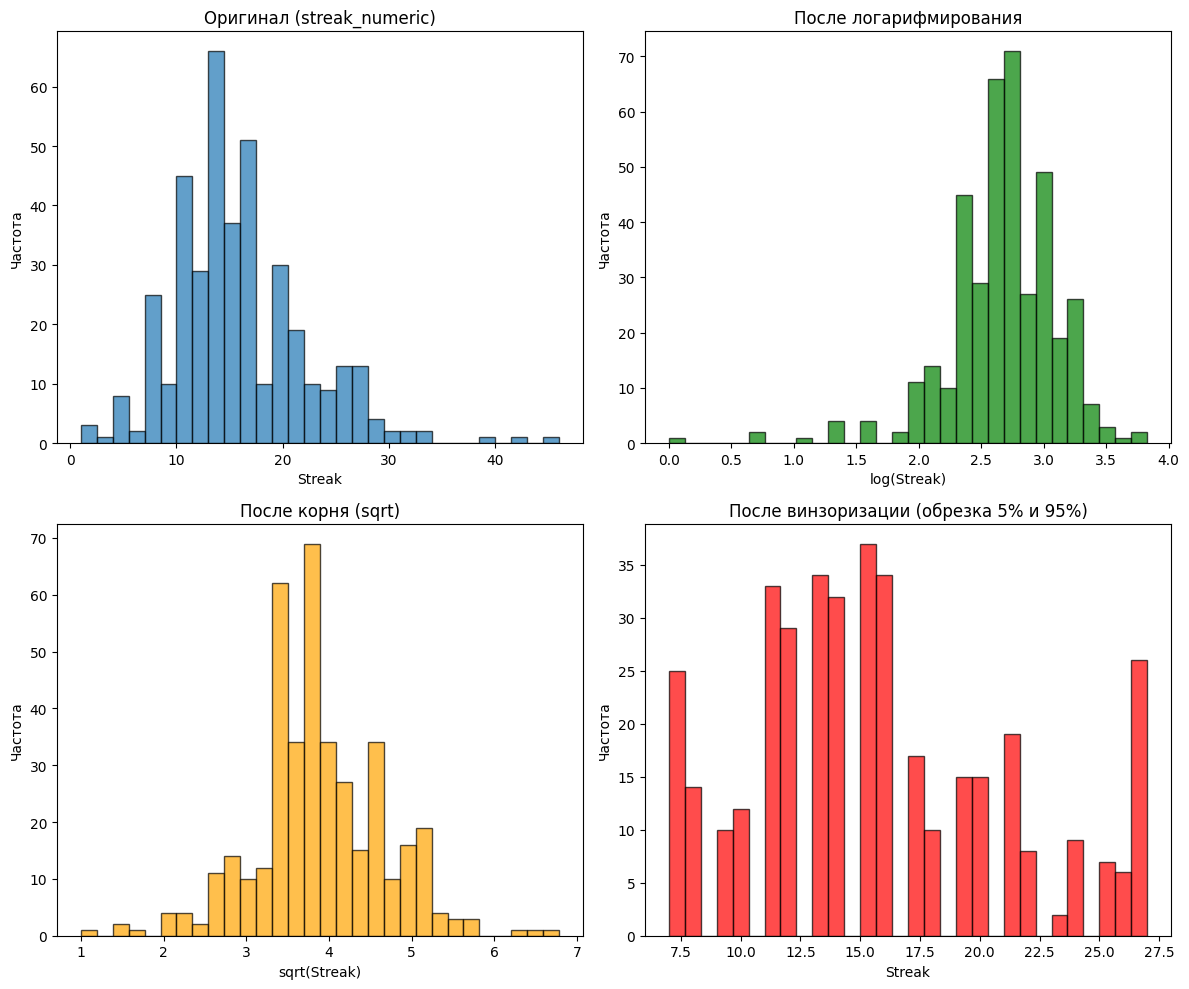

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Исходные данные (уберём пропуски)
streak_clean = df['streak_numeric'].dropna()

# Применяем преобразования
streak_log = np.log(streak_clean)  # логарифм
streak_sqrt = np.sqrt(streak_clean)  # корень

# Винзоризация (замена крайних 5% на границы)
p1 = np.percentile(streak_clean, 5)  # 5-й перцентиль
p99 = np.percentile(streak_clean, 95)  # 95-й перцентиль
streak_winsor = streak_clean.clip(lower=p1, upper=p99)

# Создаём график
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Оригинал
axes[0, 0].hist(streak_clean, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Оригинал (streak_numeric)')
axes[0, 0].set_xlabel('Streak')
axes[0, 0].set_ylabel('Частота')

# Логарифм
axes[0, 1].hist(streak_log, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('После логарифмирования')
axes[0, 1].set_xlabel('log(Streak)')
axes[0, 1].set_ylabel('Частота')

# Корень
axes[1, 0].hist(streak_sqrt, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('После корня (sqrt)')
axes[1, 0].set_xlabel('sqrt(Streak)')
axes[1, 0].set_ylabel('Частота')

# Винзоризация
axes[1, 1].hist(streak_winsor, bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('После винзоризации (обрезка 5% и 95%)')
axes[1, 1].set_xlabel('Streak')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

№6. Средние, которые вводят в заблуждение

6.1
Выбранный признак: streak_numeric

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Очищаем от пропусков
streak_clean = df['streak_numeric'].dropna()

# Арифметическое среднее
arith_mean = np.mean(streak_clean)

# Медиана
median = np.median(streak_clean)

# Геометрическое среднее (через логарифмы)
geo_mean = np.exp(np.mean(np.log(streak_clean)))

print(f"Арифметическое среднее: {arith_mean:.2f}")
print(f"Медиана: {median:.2f}")
print(f"Геометрическое среднее: {geo_mean:.2f}")

Арифметическое среднее: 15.63
Медиана: 15.00
Геометрическое среднее: 14.34


6.2
Почему они различаются:
Арифметическое (15.63) > Медиана (15.00)
Это классический признак положительной асимметрии (длинный хвост справа).
Несколько песен с очень большим streak (46 недель) «тянут» среднее вверх(завышено из-за небольшого числа песен-рекордсменов).

Геометрическое (14.34) < Арифметического (15.63)
Геометрическое среднее всегда меньше или равно арифметическому при наличии разброса.
Оно «наказывает» за большие отклонения и лучше отражает типичное значение.

Лучший показатель для описания «типичного» значения — МЕДИАНА (Не чувствительна к выбросам, показывает центр распределения).

№7. Неправильная диаграмма

7.1
Выбранная визуализация: Столбчатая диаграмма «Топ-10 исполнителей по количеству песен в рейтинге».
Для отображения этих данных хуже всего подошла бы круговая диаграмма, потому что:
На столбчатой диаграмме мы сразу видим, что The Beatles почти в 3 раза больше, чем Little Richard. На круговой диаграмме пришлось бы мысленно сравнивать углы секторов или ждать подписей с процентами.
Столбчатая диаграмма явно показывает порядок (от лидера к десятому месту). Круговая диаграмма часто не имеет естественного порядка чтения — глаза зрителя начинают с самого большого сектора, но это не всегда первый в рейтинге.
Если бы мы показали не топ-10, а всех исполнителей, круговая диаграмма превратилась бы в  десятки мелких кусочков.
Она искажает пропорции, скрывает порядок и вводит зрителя в заблуждение относительно реального веса исполнителей в общем рейтинге.

7.2
Посмотрев на круговую диаграмму, зритель мог бы подумать, что:
Разница между "The Beatles" и "Bob Dylan" такая же, как между "Elvis" и "Stones", хотя это не так(На круге углы похожи, но числа разные: 30 и 23 и 18 и 16).
"Little Richard" почти не представлен в рейтинге.(На самом деле 10 песен — это достойный результат, просто на фоне лидеров он теряется).

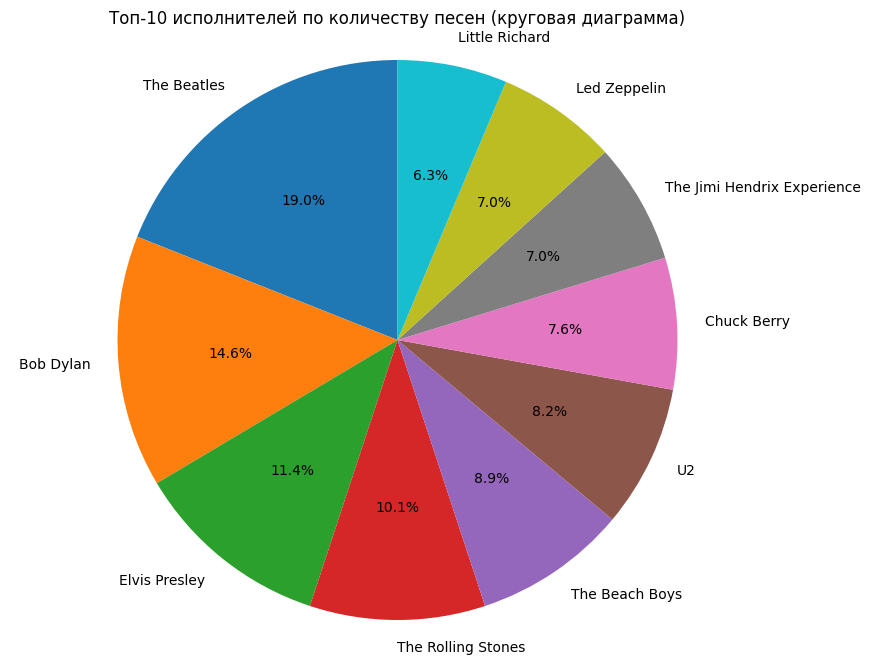

In [186]:
import matplotlib.pyplot as plt
import pandas as pd

# Твои точные данные
data = {
    'artist': ['The Beatles', 'Bob Dylan', 'Elvis Presley', 'The Rolling Stones', 
               'The Beach Boys', 'U2', 'Chuck Berry', 'The Jimi Hendrix Experience', 
               'Led Zeppelin', 'Little Richard'],
    'count': [30, 23, 18, 16, 14, 13, 12, 11, 11, 10]
}
df_top = pd.DataFrame(data)

# Круговая диаграмма (одна!)
plt.figure(figsize=(10, 8))
plt.pie(df_top['count'], labels=df_top['artist'], autopct='%1.1f%%', startangle=90)
plt.title('Топ-10 исполнителей по количеству песен (круговая диаграмма)')
plt.axis('equal')  # Чтобы круг был кругом, а не овалом
plt.show()

№8. Одна и та же информация - разные графики
Выбранная пара признаков: released_year (год выпуска) и streak_numeric (недели в чартах)

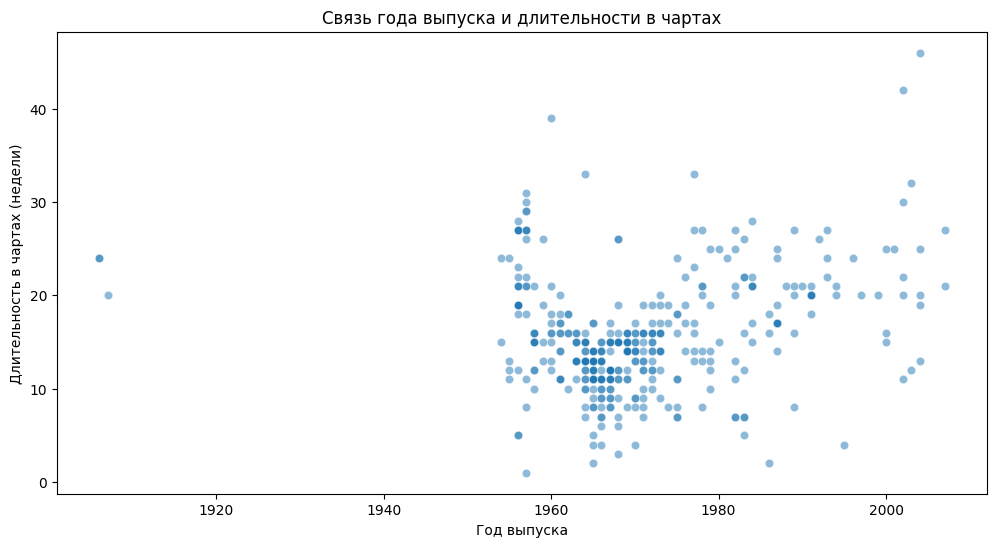

In [189]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='release_year', y='streak_numeric', alpha=0.5)
plt.title('Связь года выпуска и длительности в чартах')
plt.xlabel('Год выпуска')
plt.ylabel('Длительность в чартах (недели)')
plt.show()


Диаграмма рассеяния (scatter plot). Показать связь между двумя числовыми признаками.
Каждая точка — отдельная песня.
Мы видим: Есть ли зависимость (например, чем новее песня, тем дольше она в чартах); есть ли выбросы (песни, которые сильно выбиваются), как сконцентрированы данные (где точек много, где мало).

(scatter plot) подчёркивает:
1)Каждую песню индивидуально(Каждая точка — отдельная песня со своим годом и streak);
2)Общий тренд во времени(Если точки ползут вверх/вниз справа налево — есть зависимость от года);
3)Выбросы(Точки, которые далеко от основной массы (например, старая песня с очень высоким streak));
4)Плотность скоплений(Где точек больше всего — это года, в которые выходило больше всего песен);
5)Границы данных (Самый старый год, самый высокий streak).

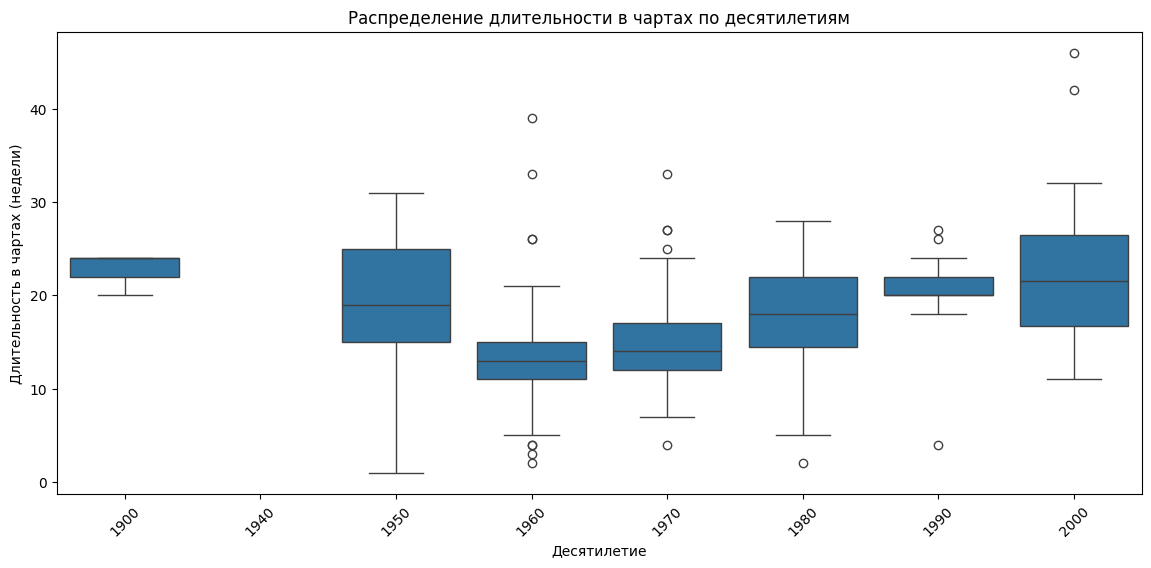

In [188]:
# Создаём десятилетия
df['decade'] = (df['release_year'] // 10) * 10

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='decade', y='streak_numeric')
plt.title('Распределение длительности в чартах по десятилетиям')
plt.xlabel('Десятилетие')
plt.ylabel('Длительность в чартах (недели)')
plt.xticks(rotation=45)
plt.show()

Группируем песни по десятилетиям и смотрим распределение streak внутри каждой группы.
Мы видим: медиану (типичное значение) — линия внутри ящика; разброс (от 25-го до 75-го перцентиля) — сам ящик; выбросы — точки за усами; асимметрию — если медиана не по центру ящика; сравнение групп — несколько ящиков рядом.

Boxplot подчёркивает:
1)Типичное значение для каждой эпохи (Медиана (линия в ящике) показывает, сколько в среднем держались песни в этом десятилетии);
2)Разброс внутри десятилетия (Высота ящика — насколько разнообразными были песни по длительности);
3)Сравнение эпох (Несколько ящиков рядом — сразу видно, где медиана выше, а где ниже);
4)Стабильность (Так как ящики неодинаковые — распределение  менялось со временем);
5)Выбросы по эпохам	(Точки за усами показывают песни-рекордсмены в каждом десятилетии).

8.2
Гипотезы, которые легче заметить на scatter plot:
«В последние годы появились песни с аномально долгим пребыванием в чартах»- Сразу видно отдельные точки, уходящие высоко вверх в правой части графика.
«Есть ли вообще связь между годом и streak?»- Облако точек показывает направление: если точки ползут вверх — связь есть.
«В какие годы было больше всего хитов?»	- Где точки расположены плотнее всего — там и пик.
«Есть ли песни, которые выбиваются из общего тренда?»- Выбросы видны как изолированные точки.


Гипотезы, которые легче заметить на boxplot:
«В 1970-х песни в среднем держались дольше, чем в 1960-х» -	Сравниваем медианы (линии в ящиках) — это занимает секунду.
«В каком десятилетии самый большой разброс по длительности?» - Самый высокий ящик сразу бросается в глаза.
«В каждом десятилетии есть свои рекордсмены?»- Точки за усами видны для каждого ящика.
«Как менялась типичная длительность от эпохи к эпохе?»	-Линия медиан по ящикам  даёт тренд.

Scatter plot нужен, чтобы увидеть общую картину и исключения.
Boxplot нужен, чтобы сравнивать эпохи и понимать типичные значения.